In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import dpmm
%matplotlib inline

In [2]:
# Define a Gaussian Mixture model to test with

class gauss(object):
    def __init__(self, mu, V):
        self.mu = mu # Mean
        self.V = V # Variance

    def sample(self, size=None):
        return np.random.normal(loc=self.mu, scale=np.sqrt(self.V), size=size)

    def __call__(self, x): # Probability density
        return np.exp(-0.5*(x-self.mu)**2/self.V)/np.sqrt(2*np.pi*self.V)

# Mixture model
class MM(object):
    def __init__(self, components, proportions):
        self.components = components
        self.proportions = proportions

    def sample(self, size=None):
        if size is None:
            nums = np.random.multinomial(1, self.proportions)
            c = num.index(1) # which class got picked
            return self.components[c].sample()
        else:
            out = np.empty((size,), dtype=float)
            nums = np.random.multinomial(size, self.proportions)
            i = 0
            for component, num in zip(self.components, nums):
                out[i:i+num] = component.sample(size=num)
                i += num
            return out

    def __call__(self, x):
        return np.sum([p*c(x) for p, c in zip(self.proportions, self.components)], axis=0)

    def plot(self, axis=None, **kwargs):
        """ Plot the mixture model pdf."""
        if axis is None:
            axis = plt.gca()
        x = np.arange(-2,2,0.01)
        y = self(x)
        axis.plot(x, y, **kwargs)

In [3]:
# Mixture model parameters
mu = [-0.5, 0.0, 0.7]  # means
V = [0.02, 0.03, 0.1]  # variances
p = [0.25, 0.4, 0.35]  # proportions
model = MM([gauss(mu0, V0) for mu0, V0 in zip(mu, V)], p)

/Users/josh/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


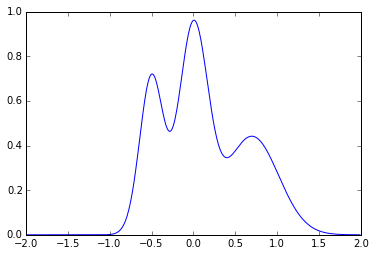

In [4]:
# Plot the generative mixture model
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
model.plot(axis=ax)
f.show()

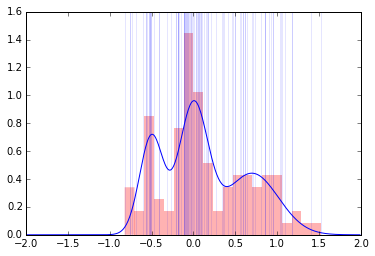

In [5]:
# Draw some samples with which to do inference, and plot them.
data = model.sample(size=100) # 100 samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for x in data:
    ax.axvline(x, alpha=0.1)
ax.hist(data, 20, normed=True, color='r', alpha=0.3)
f.show()

In [6]:
# Create the Dirichlet Process Mixture Model.
# Use one of the priors from dpmm/prior.py, which knows all about likelihood and their conjugate priors.
# For this example, we'll infer a Gaussian mixture model where the components all have known variance but 
# unknown means.
mu_0 = 0.0
sigsqr_0 = 1.0 # Variance of prior over mixture component means
sigsqr = 0.05 # Assert a known variance of mixture components.  Turns out to be the wrong variance...
cp = dpmm.GaussianMeanKnownVariance(mu_0, sigsqr_0, sigsqr)
alpha = 0.1 # Dirichlet Process clustering parameter.  Set higher to infer more components, lower to infer fewer.
dp = dpmm.DPMM(cp, alpha, data)

In [7]:
# Burn-in
dp.update(1000)

In [8]:
phis = []
nphis = []
# Sample
for i in xrange(100):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy and not a reference.
    nphis.append(list(dp.nphi))

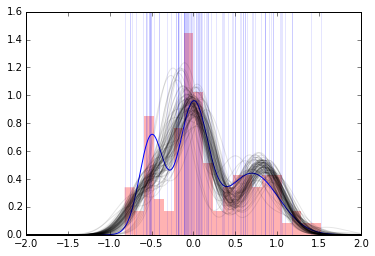

In [9]:
def plot_sample(phi, nphi, axis=None, **kwargs):
    x = np.arange(-2, 2, 0.01)
    y = np.zeros_like(x)
    for ph, n in zip(phi, nphi):
        mu = ph
        y += n*np.exp(-0.5*(x-mu)**2/sigsqr)/np.sqrt(2*np.pi*sigsqr)/sum(nphi)
    if axis is None:
        axis = plt.gca()
    axis.plot(x, y, **kwargs)

# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for x in data:
    ax.axvline(x, alpha=0.1)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.hist(data, 20, normed=True, alpha=0.3, color='r')
f.show()

In [10]:
# We weren't quite able to capture the structure in the data when only letting the component means to float, so
# try again but this time let the component variances also float.  This requires either a Normal-Inverse-ChiSquare
# prior, or equivalently, a Normal-Inverse-Gamma.
mu_0 = 0.3
kappa_0 = 0.1
sigsqr_0 = 1.0
nu_0 = 0.1
cp = dpmm.NormInvChi2(mu_0, kappa_0, sigsqr_0, nu_0)
alpha = 10.0
dp2 = dpmm.DPMM(cp, alpha, data)

In [11]:
dp2.update(100)

In [12]:
phis = []
nphis = []
# Sample
for i in xrange(100):
    dp2.update(10)
    phis.append(list(dp2.phi))
    nphis.append(list(dp2.nphi))

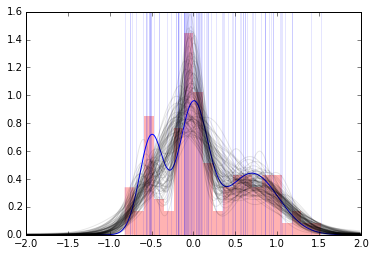

In [13]:
def plot_sample2(phi, nphi, axis=None, **kwargs):
    x = np.arange(-2, 2, 0.01)
    y = np.zeros_like(x)
    for ph, n in zip(phi, nphi):
        mu, var = ph
        y += n*np.exp(-0.5*(x-mu)**2/var)/np.sqrt(2*np.pi*var)/sum(nphi)
    if axis is None:
        axis = plt.gca()
    axis.plot(x, y, **kwargs)

# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for x in data:
    ax.axvline(x, alpha=0.1)
for phi, nphi in zip(phis, nphis):
    plot_sample2(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.hist(data, 20, normed=True, alpha=0.3, color='r')
f.show()

In [14]:
# Should be able to get statistically identical results from a NIG prior with corresponding hyperparameters.
m_0 = mu_0
V_0 = 1./kappa_0
a_0 = nu_0/2.0
b_0 = nu_0*sigsqr_0/2.0
cp = dpmm.NormInvGamma(m_0, V_0, a_0, b_0)
alpha = 10.0
dp3 = dpmm.DPMM(cp, alpha, data)

In [15]:
dp3.update(100)

In [16]:
phis = []
nphis = []
# Sample
for i in xrange(100):
    dp3.update(10)
    phis.append(list(dp3.phi))
    nphis.append(list(dp3.nphi))

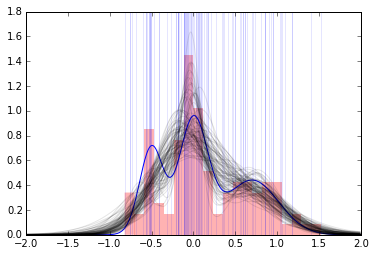

In [17]:
def plot_sample2(phi, nphi, axis=None, **kwargs):
    x = np.arange(-2, 2, 0.01)
    y = np.zeros_like(x)
    for ph, n in zip(phi, nphi):
        mu, var = ph
        y += n*np.exp(-0.5*(x-mu)**2/var)/np.sqrt(2*np.pi*var)/sum(nphi)
    if axis is None:
        axis = plt.gca()
    axis.plot(x, y, **kwargs)

# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for x in data:
    ax.axvline(x, alpha=0.1)
for phi, nphi in zip(phis, nphis):
    plot_sample2(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.hist(data, 20, normed=True, alpha=0.3, color='r')
f.show()